# Imports 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import common_functions as hf
from tensorflow import keras 
from tensorflow.keras import layers 
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import sklearn as sk
from sklearn.metrics import confusion_matrix
import itertools

# Getting Data 

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls - pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filename_pos = []
for filename in filenames :
  if filename.split("sign/")[1]=="dev.txt":
    filename_pos.append("val")
  elif filename.split("sign/")[1]=="test.txt":
    filename_pos.append("test")
  else:
    filename_pos.append("train")
filename_pos

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
ls: cannot access '-': No such file or directory
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign:
dev.txt  test.txt  train.txt


['train', 'test', 'val']

In [3]:
def get_lines(filename):
  """
  Returns lines of a text as list 
  """
  with open(filename, "r") as f:
    return f.readlines()

def preprocess_textfile(filename):
  
  data_dictionary_list = []
  abstract_id = -1
  abstractLines = ""

  for line in get_lines(filename):
  
    if line.startswith("###"):
      abstractLines=""
      abstract_id = (line.split("###")[1]).split()[0]
    elif line.isspace():
      for i, abstract_line in enumerate(abstractLines.splitlines()):
        abstract_line_split = abstract_line.split("\t")
        data_dictionary_list.append({
            "abstract_id" : abstract_id,
            "line_no": i,
            "target": abstract_line_split[0],
            "text": abstract_line_split[1].lower(),
            "total_lines": len(abstractLines.splitlines())
        })
    else:
      abstractLines+=line 

  return data_dictionary_list

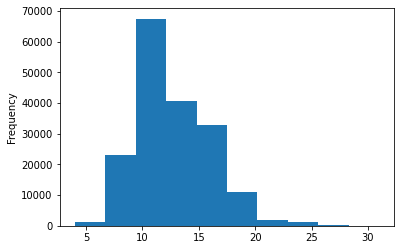

In [4]:
val_data_bundle = preprocess_textfile(filenames[filename_pos.index("val")]) 
train_data_bundle = preprocess_textfile(filenames[filename_pos.index("train")])  
test_data_bundle = preprocess_textfile(filenames[filename_pos.index("test")]) 

val_df = pd.DataFrame(val_data_bundle)
train_df = pd.DataFrame(train_data_bundle)
test_df = pd.DataFrame(test_data_bundle)

train_df.total_lines.plot.hist()
train_df.target.value_counts()

val_sentences = val_df.text.tolist()
train_sentences = train_df.text.tolist()
test_sentences = test_df.text.tolist()

# One Hot encoding labels 

In [5]:
one_hot_encdoer = sk.preprocessing.OneHotEncoder(sparse = False)

val_labels_oneHot = one_hot_encdoer.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
train_labels_oneHot = one_hot_encdoer.transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_oneHot = one_hot_encdoer.transform(test_df["target"].to_numpy().reshape(-1,1))

label_encoder = sk.preprocessing.LabelEncoder()

val_labels_encoded  = label_encoder.fit_transform(val_df["target"].to_numpy())
train_labels_encoded  = label_encoder.transform(train_df["target"].to_numpy())
test_labels_encoded  = label_encoder.transform(test_df["target"].to_numpy())

# Declaring some constants 

In [6]:
NUM_CLASSES = len(label_encoder.classes_)
CLASS_NAMES = label_encoder.classes_

# Naive Bayes baseline model

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_base = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_base.fit(train_sentences, train_labels_encoded)
model_base.score(val_sentences, val_labels_encoded)

model_base_results = hf.calculate_results(val_labels_encoded, model_base.predict(val_sentences))

# Vectorization and Embedding

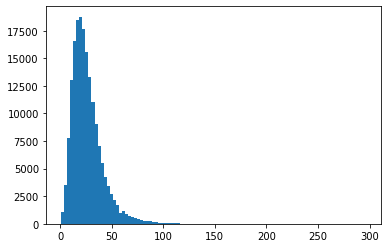

In [8]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_length = np.mean(sentence_lengths)
plt.hist(sentence_lengths, bins=100)
output_seq_length = int(np.percentile(sentence_lengths, 95))

text_vectorizor = layers.TextVectorization(max_tokens = 68000, output_sequence_length = output_seq_length)
text_vectorizor.adapt(train_sentences)
embedding_layer_model1 = layers.Embedding(input_dim = text_vectorizor.vocabulary_size(),
                                          output_dim = 128,
                                          mask_zero = True,
                                          name = "token_embedding")

# Making use of tf.Data for performance

In [9]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_oneHot))
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_oneHot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_oneHot))

val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model 1 Conv1D Deep model

In [10]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizor(inputs)
x = embedding_layer_model1(x)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu") (x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(NUM_CLASSES, activation = "softmax")(x)

model_1 = keras.Model(inputs, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

# Compiling and fitting Model 1

In [11]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_model_1 = model_1.fit(train_dataset, validation_data = val_dataset, epochs = 3, 
                              steps_per_epoch = .1 * int(len(train_dataset)), validation_steps = .25 * int(len(val_dataset)) )

Epoch 1/3
562/562 [==============================] - 61s 106ms/step - loss: 0.9079 - accuracy: 0.6426 - val_loss: 0.6896 - val_accuracy: 0.7381
Epoch 2/3
562/562 [==============================] - 62s 111ms/step - loss: 0.6628 - accuracy: 0.7523 - val_loss: 0.6506 - val_accuracy: 0.7666
Epoch 3/3
562/562 [==============================] - 64s 115ms/step - loss: 0.6243 - accuracy: 0.7699 - val_loss: 0.6029 - val_accuracy: 0.7865


# Evaluating Model 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

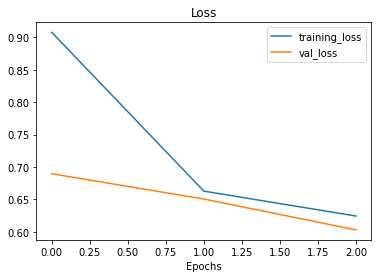

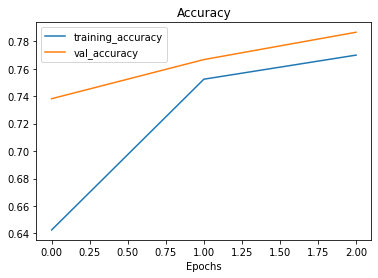

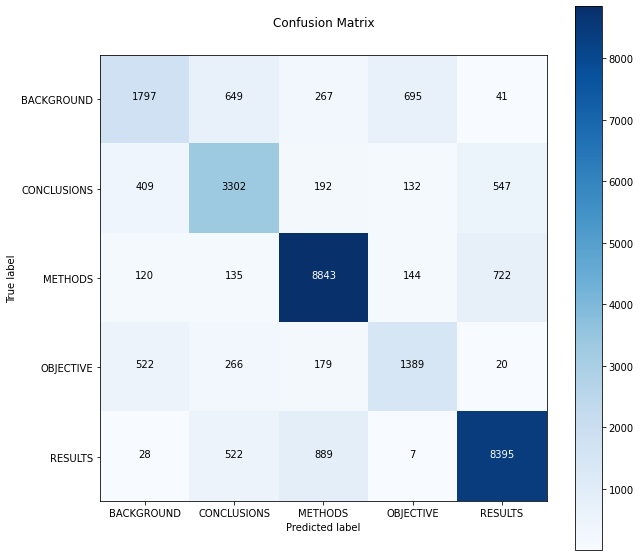

In [12]:
model_1.summary()
model_1.evaluate(val_dataset)
hf.plot_loss_curves(history_model_1)
hf.make_confusion_matrix(val_labels_encoded, model_1.predict(val_dataset)[:].argmax(axis=1), classes = CLASS_NAMES)
model_1_results = hf.calculate_results(val_labels_encoded,model_1.predict(val_dataset)[:].argmax(axis=1))

# Model 2 Feature Extraction 

In [13]:
USE_baseModel = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")
inputs = layers.Input(shape=[], dtype="string")
x = USE_baseModel(inputs)
x = layers.Dense(128, activation="relu") (x)
outputs = layers.Dense(5, activation="softmax") (x)

model_2 = keras.Model(inputs, outputs)

# Compiling and fitting Model 2

In [14]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_model_2 = model_2.fit(train_dataset, validation_data = val_dataset, epochs = 3, 
                              steps_per_epoch = 1 * int(len(train_dataset)), validation_steps = .25 * int(len(val_dataset)) )

Epoch 1/3
5627/5627 [==============================] - 76s 13ms/step - loss: 0.7276 - accuracy: 0.7220 - val_loss: 0.6594 - val_accuracy: 0.7488
Epoch 2/3
5627/5627 [==============================] - 72s 13ms/step - loss: 0.6343 - accuracy: 0.7595 - val_loss: 0.6246 - val_accuracy: 0.7621
Epoch 3/3
5627/5627 [==============================] - 74s 13ms/step - loss: 0.6003 - accuracy: 0.7733 - val_loss: 0.6115 - val_accuracy: 0.7673


# Evaluating Model 2

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________
945/945 [==============================] - 12s 13ms/step - loss: 0.6079 - accuracy: 0.7690


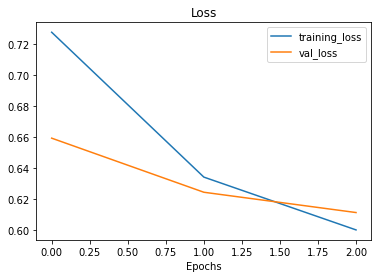

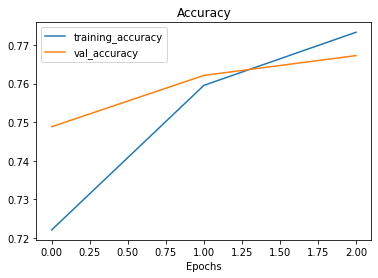

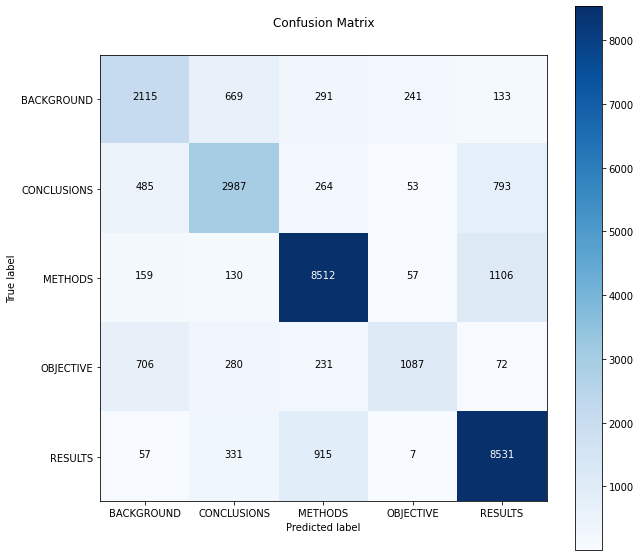

In [15]:
model_2.summary()
model_2.evaluate(val_dataset)
hf.plot_loss_curves(history_model_2)
hf.make_confusion_matrix(val_labels_encoded, model_2.predict(val_dataset)[:].argmax(axis=1), classes = CLASS_NAMES)
model_2_results = hf.calculate_results(val_labels_encoded,model_2.predict(val_dataset)[:].argmax(axis=1))

# Character Level Embedding

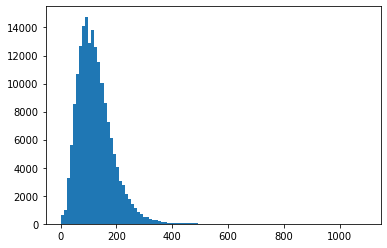

In [16]:
def split_chars(text):
  return " ".join(list(text))

val_chars = [split_chars(sentence) for sentence in val_sentences]
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

char_lengths = [len(char_sentence.split()) for char_sentence in train_chars]
avg_char_length = np.mean(char_lengths)
output_char_seq_length = int(np.percentile(char_lengths, 95))
plt.hist(char_lengths, bins=100)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_oneHot))
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_oneHot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_oneHot))

val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
import string
NUM_CHAR_TOKEN = len(string.ascii_lowercase) + len(string.digits) + len(string.punctuation) + 2
text_vectorizor_char_level = layers.TextVectorization(max_tokens = NUM_CHAR_TOKEN,
                                                      output_sequence_length = output_char_seq_length)
text_vectorizor_char_level.adapt(train_chars)
char_embedding_layer_model_3 = layers.Embedding(input_dim = text_vectorizor_char_level.vocabulary_size(),
                                                            output_dim = 25,
                                                            mask_zero = False,
                                                            name = "char_embedding")

# Model 3 Conv1D with char embedding

In [18]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizor_char_level(inputs)
x = char_embedding_layer_model_3(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(NUM_CLASSES, activation = "softmax")(x)

model_3 = keras.Model(inputs, outputs)

# Compiling and Fitting Model 3

In [19]:
model_3.compile(loss = "categorical_crossentropy",
                optimizer = keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_model_3 = model_3.fit(train_char_dataset, validation_data = val_char_dataset, epochs = 3, 
                              steps_per_epoch = int(1 * len(train_char_dataset)), validation_steps = int(.25 * len(val_char_dataset)) )

Epoch 1/3
5627/5627 [==============================] - 124s 22ms/step - loss: 0.8940 - accuracy: 0.6520 - val_loss: 0.7775 - val_accuracy: 0.7001
Epoch 2/3
5627/5627 [==============================] - 124s 22ms/step - loss: 0.7463 - accuracy: 0.7163 - val_loss: 0.7320 - val_accuracy: 0.7250
Epoch 3/3
5627/5627 [==============================] - 125s 22ms/step - loss: 0.7152 - accuracy: 0.7301 - val_loss: 0.7040 - val_accuracy: 0.7364


# Evaluating Model 3

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 239)              0         
 ectorization)                                                   
                                                                 
 char_embedding (Embedding)  (None, 239, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 239, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

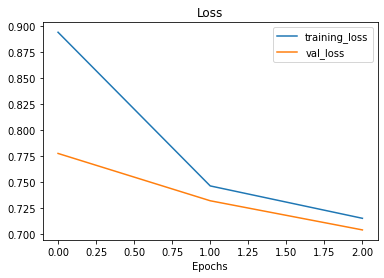

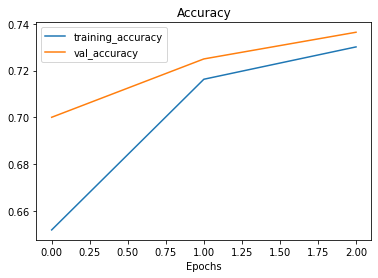

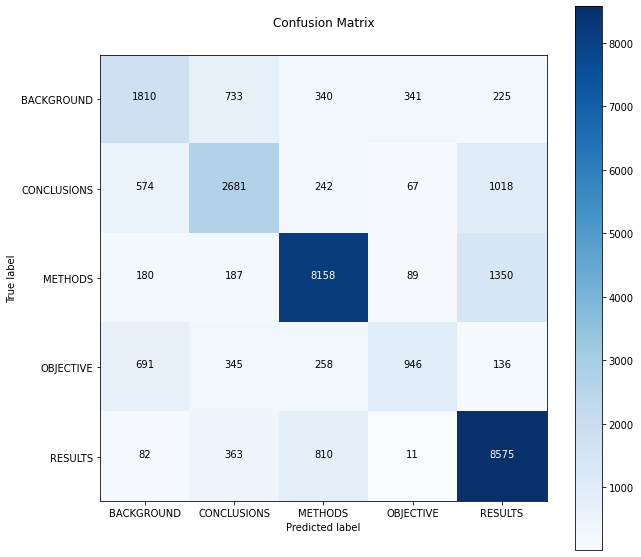

In [20]:
model_3.summary()
model_3.evaluate(val_dataset)
hf.plot_loss_curves(history_model_3)
hf.make_confusion_matrix(val_labels_encoded, model_3.predict(val_char_dataset)[:].argmax(axis=1), classes = CLASS_NAMES)
model_3_results = hf.calculate_results(val_labels_encoded,model_3.predict(val_char_dataset)[:].argmax(axis=1))

# Model 4 (char+word embedding)

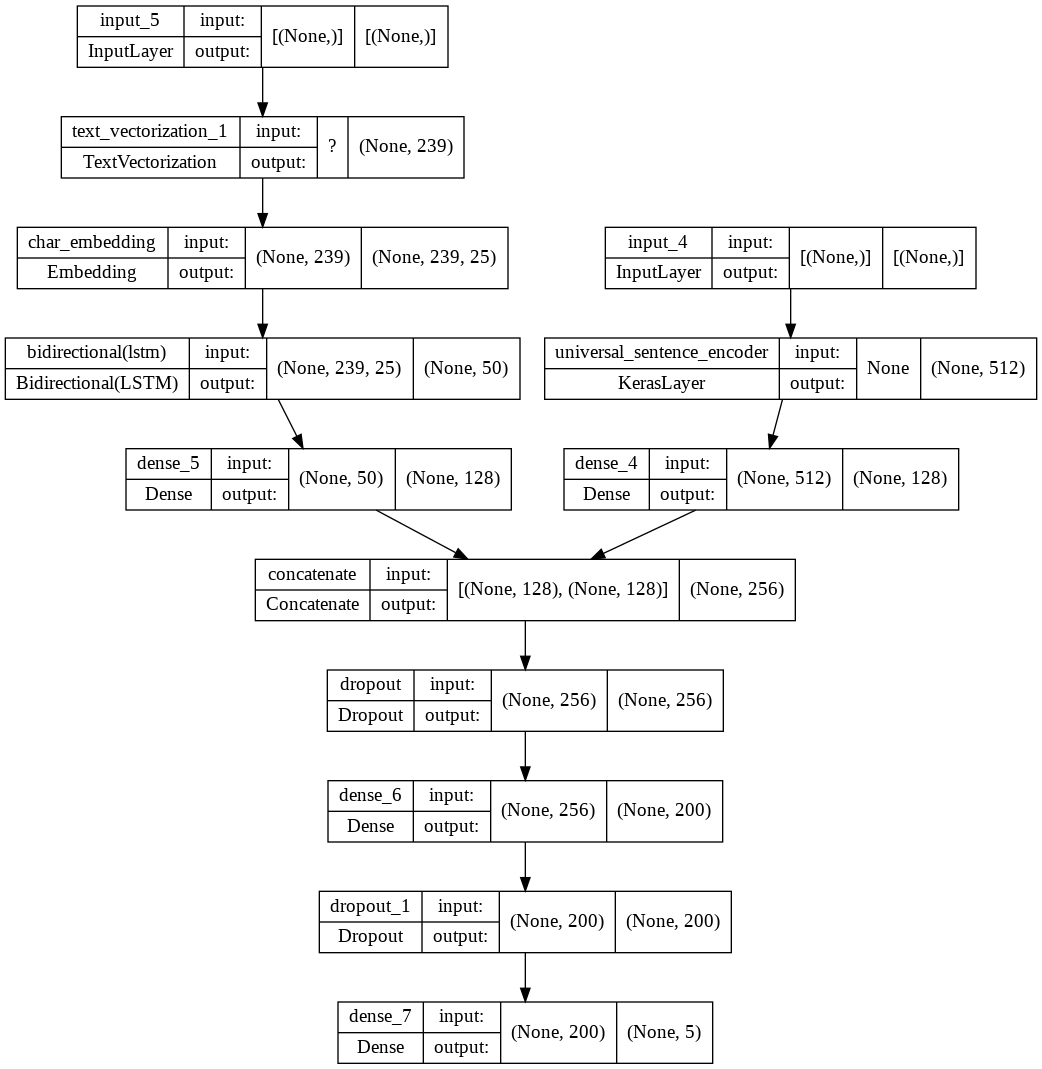

In [21]:
char_embedding_layer_model_4 = layers.Embedding(input_dim = text_vectorizor_char_level.vocabulary_size(),
                                                            output_dim = 25,
                                                            mask_zero = False,
                                                            name = "char_embedding")
#1
word_inputs = layers.Input(shape=[], dtype="string")
word_embeddings = USE_baseModel(word_inputs)
word_outputs = layers.Dense(128, activation="relu")(word_embeddings)

word_model = keras.Model(word_inputs, word_outputs)

#2
char_inputs = layers.Input(shape=[], dtype="string")
char_vectors = text_vectorizor_char_level(char_inputs)
char_embeddings = char_embedding_layer_model_4(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_outputs = layers.Dense(128, activation = "relu") (char_bi_lstm)

char_model = keras.Model(char_inputs, char_outputs)

#3 
hybrid_embedding = layers.Concatenate()([word_model.output, char_model.output])
drop_out_layer_1 = layers.Dropout(.5)(hybrid_embedding)
dense_layer_1 = layers.Dense(200, activation="relu")(drop_out_layer_1)
drop_out_layer_2 = layers.Dropout(.5)(dense_layer_1)
outputs = layers.Dense(NUM_CLASSES, activation="softmax") (drop_out_layer_2)

model_4 = keras.Model(inputs=[word_model.input, char_model.input], outputs = outputs)
tf.keras.utils.plot_model(model_4, show_shapes=True)
#model_4 = keras.Model(inputs=[word_model.input, char_model.input], outputs) python inference messes up here lol

# plot_model doesnt seem to care about the input sequence order it doesnt maintain it smh

# Preparing Data

In [22]:
#take care of the word,char or char/word sequence - depends on inputs=[word, char] sequnece
val_hybrid_dataset_inputData = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
train_hybrid_dataset_inputData = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
test_hybrid_dataset_inputData = tf.data.Dataset.from_tensor_slices((test_chars, test_sentences))

val_hybrid_dataset_labels = tf.data.Dataset.from_tensor_slices(val_labels_oneHot)
train_hybrid_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels_oneHot)
test_hybrid_dataset_labels =tf.data.Dataset.from_tensor_slices(test_labels_oneHot)

val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_dataset_inputData, val_hybrid_dataset_labels))
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_dataset_inputData, train_hybrid_dataset_labels))
test_hybrid_dataset = tf.data.Dataset.zip((test_hybrid_dataset_inputData, test_hybrid_dataset_labels))

val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_hybrid_dataset = test_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Compiling and Fitting Model 4

In [23]:
model_4.compile(loss = "categorical_crossentropy",
                optimizer = keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_model_4 = model_4.fit(train_hybrid_dataset, validation_data = val_hybrid_dataset, epochs = 3, 
                              steps_per_epoch = int(.1 * len(train_hybrid_dataset)), validation_steps = int(.1 * len(val_hybrid_dataset)) )

Epoch 1/3
562/562 [==============================] - 138s 235ms/step - loss: 0.9681 - accuracy: 0.6134 - val_loss: 0.7808 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 137s 243ms/step - loss: 0.7952 - accuracy: 0.6926 - val_loss: 0.7128 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 140s 250ms/step - loss: 0.7645 - accuracy: 0.7061 - val_loss: 0.6894 - val_accuracy: 0.7394


# Evaluating Model 4

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 239)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, 239, 25)      700         ['text_vectorization_1[1][0

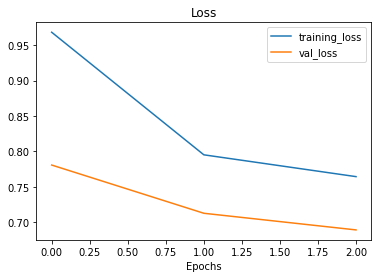

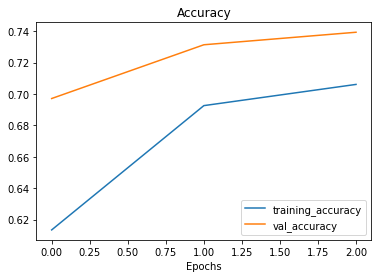

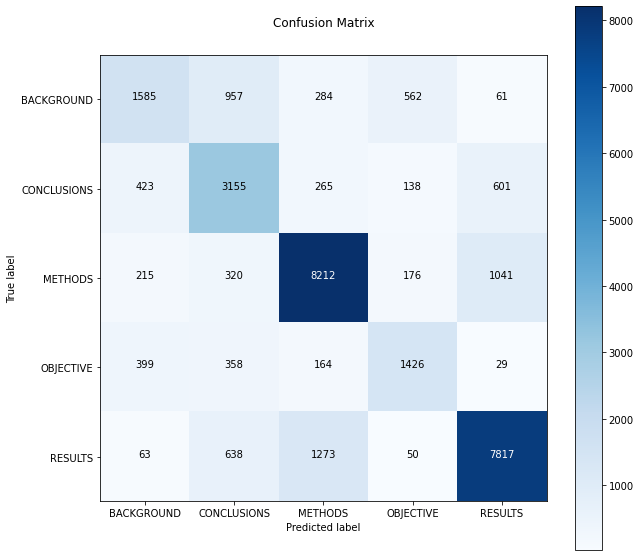

In [24]:
model_4.summary()
model_4.evaluate(val_hybrid_dataset)
hf.plot_loss_curves(history_model_4)
hf.make_confusion_matrix(val_labels_encoded, model_4.predict(val_hybrid_dataset)[:].argmax(axis=1), classes = CLASS_NAMES)
model_4_results = hf.calculate_results(val_labels_encoded,model_4.predict(val_hybrid_dataset)[:].argmax(axis=1))

# Preparing Data for feature engineering

In [25]:
val_df = val_df.assign(rel_pos = val_df["line_no"]/val_df["total_lines"])
train_df = train_df.assign(rel_pos = train_df["line_no"]/train_df["total_lines"])
test_df = test_df.assign(rel_pos = test_df["line_no"]/test_df["total_lines"])

val_dataset_inputData_CWP = tf.data.Dataset.from_tensor_slices((tf.one_hot(val_df["rel_pos"].to_numpy()*100, depth=30),val_sentences,val_chars))
train_dataset_inputData_CWP = tf.data.Dataset.from_tensor_slices((tf.one_hot(train_df["rel_pos"].to_numpy()*100, depth=30),train_sentences,train_chars))
test_dataset_inputData_CWP = tf.data.Dataset.from_tensor_slices((tf.one_hot(test_df["rel_pos"].to_numpy()*100, depth=30),test_chars, test_sentences))
#val_dataset_inputData_CWP = tf.data.Dataset.from_tensor_slices((val_df["rel_pos"].to_numpy(),val_sentences,val_chars))
#train_dataset_inputData_CWP = tf.data.Dataset.from_tensor_slices((train_df["rel_pos"].to_numpy(),train_sentences,train_chars))
#test_dataset_inputData_CWP = tf.data.Dataset.from_tensor_slices((test_df["rel_pos"].to_numpy(),test_chars, test_sentences))

val_CWP_dataset = tf.data.Dataset.zip((val_dataset_inputData_CWP, val_hybrid_dataset_labels))
train_CWP_dataset = tf.data.Dataset.zip((train_dataset_inputData_CWP, train_hybrid_dataset_labels))
test_CWP_dataset = tf.data.Dataset.zip((test_dataset_inputData_CWP, test_hybrid_dataset_labels))

val_CWP_dataset = val_CWP_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_CWP_dataset = train_CWP_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_CWP_dataset = test_CWP_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Model 5 (char + word + pos) embedding

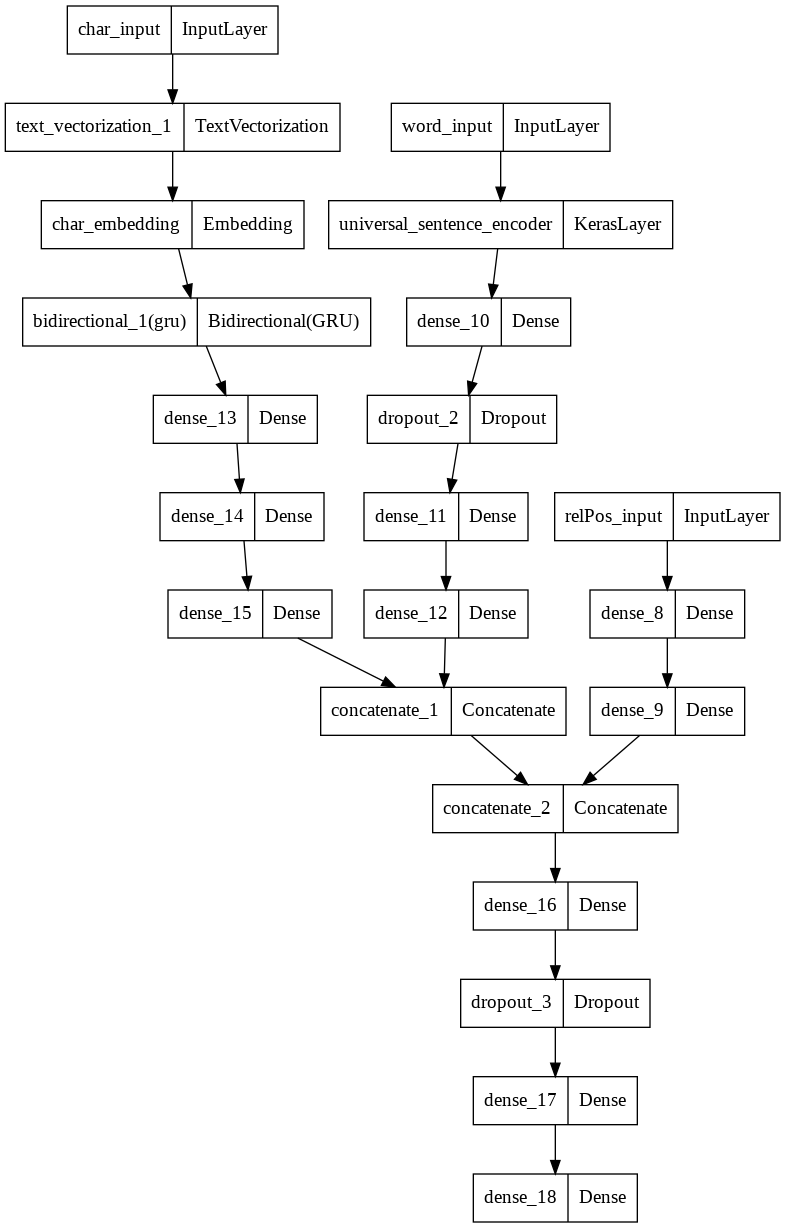

In [26]:
# feature engineering 

char_embedding_layer_model_5 = layers.Embedding(input_dim = text_vectorizor_char_level.vocabulary_size(),
                                                            output_dim = 25,
                                                            mask_zero = False,
                                                            name = "char_embedding")

#1
relPos_inputs = layers.Input(shape=(30,), dtype=tf.float32, name="relPos_input") 
x1 = layers.Dense(8, activation="relu") (relPos_inputs)
relPos_outputs = layers.Dense(8, activation="relu") (x1)

#2
word_inputs = layers.Input(shape=[], dtype="string", name="word_input")
word_embedded = USE_baseModel(word_inputs)
x2 = layers.Dense(256, activation = "relu") (word_embedded)
x2 = layers.Dropout(.25)(x2)
x2 = layers.Dense(64, activation = "tanh") (x2)
word_outputs = layers.Dense(32, activation="relu")(x2)

#3
char_inputs = layers.Input(shape=[], dtype="string", name="char_input")
char_vector = text_vectorizor_char_level(char_inputs)
char_embedded = char_embedding_layer_model_5(char_vector)
char_biDir_layer = layers.Bidirectional(layers.GRU(32))(char_embedded)
x3 = layers.Dense(128, activation="relu")(char_biDir_layer)
x3 = layers.Dense(.25)(x3)
char_outputs = layers.Dense(16, activation="relu")(x3)

#a
word_char_joint = layers.Concatenate()([word_outputs, char_outputs])

#b
word_char_relPos_joint = layers.Concatenate()([relPos_outputs, word_char_joint])

x = layers.Dense(64, activation="relu")(word_char_relPos_joint)
x = layers.Dropout(.25)(x)
x = layers.Dense(32, activation="relu")(x)
output_layer = layers.Dense(5, activation= "softmax")(x)

model_5 = keras.Model(inputs = [relPos_inputs, word_inputs, char_inputs],  outputs = output_layer)
tf.keras.utils.plot_model(model_5)

# Compiling and Fitting Model 5

In [27]:
model_5.compile(loss = keras.losses.CategoricalCrossentropy(),
                optimizer = keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_model_5 = model_5.fit(train_CWP_dataset, validation_data = val_CWP_dataset, epochs = 3, 
                              steps_per_epoch = int(.5 * len(train_CWP_dataset)), validation_steps = int(.1 * len(val_CWP_dataset)) )

Epoch 1/3
2813/2813 [==============================] - 598s 210ms/step - loss: 0.5895 - accuracy: 0.7688 - val_loss: 0.4855 - val_accuracy: 0.8128
Epoch 2/3
2813/2813 [==============================] - 629s 224ms/step - loss: 0.5043 - accuracy: 0.8065 - val_loss: 0.4818 - val_accuracy: 0.8128
Epoch 3/3
   1/2813 [..............................] - ETA: 8:07 - loss: 0.7764 - accuracy: 0.5000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 8439 batches). You may need to use the repeat() function when building your dataset.


2813/2813 [==============================] - 7s 2ms/step - loss: 0.7764 - accuracy: 0.5000 - val_loss: 0.4778 - val_accuracy: 0.8155


# Evaluating Model 5

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 word_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 239)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['word_input[0][0]']       

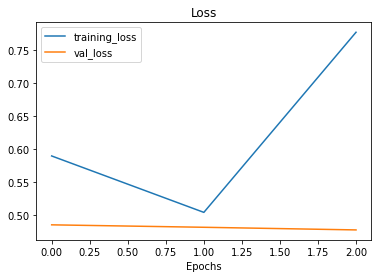

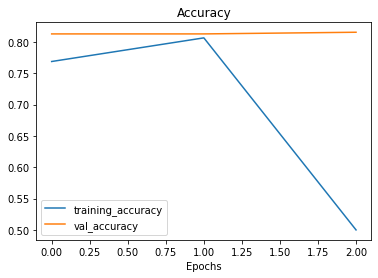

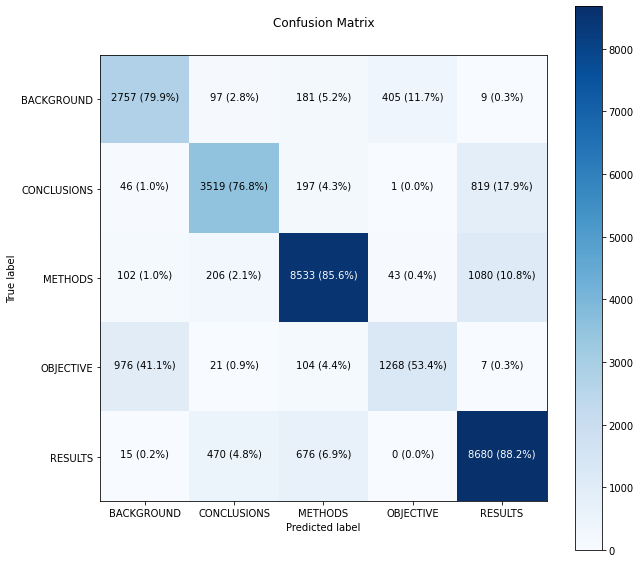

In [28]:
model_5.summary()
model_5.evaluate(val_CWP_dataset)
hf.plot_loss_curves(history_model_5)
hf.make_confusion_matrix(val_labels_encoded, model_5.predict(val_CWP_dataset)[:].argmax(axis=1), classes=CLASS_NAMES, norm = True)
model_5_results = hf.calculate_results(val_labels_encoded,model_5.predict(val_CWP_dataset)[:].argmax(axis=1))

# Making predictions on wild data

In [32]:
def turn_data_into_orignalFormat(text):
  lines = text.split(".")
  return lines
def turn_lines_into_dictionary(lines):  
  data_dictionary_list = []
  total_lines = len(lines)
  for i, abstract_line in enumerate(lines):
    if len(abstract_line)>0:
      data_dictionary_list.append({
          "relPos": i/total_lines,
          "text": abstract_line.lower(),
          "line_no": i
      })
  return data_dictionary_list

In [ ]:
def skim(text = "The increasing burden of obesity plays an essential role in increased cardiovascular morbidity and mortality. The effects of obesity on the cardiovascular system have also been demonstrated in childhood, where prevention is even more important. Obesity is associated with hormonal changes and vascular dysfunction, which eventually lead to hypertension, hyperinsulinemia, chronic kidney disease, dyslipidemia and cardiac dysfunction-all associated with increased cardiovascular risk, leading to potential cardiovascular events in early adulthood. Several preventive strategies are being implemented to reduce the cardiovascular burden in children. This paper presents a comprehensive review of obesity-associated cardiovascular morbidity with the preventive diagnostic workup at our hospital and possible interventions in children."):

  text=text.replace("1","@")
  text=text.replace("2","@")
  text=text.replace("2","@") 
  text=text.replace("3","@")
  text=text.replace("4","@")
  text=text.replace("5","@")
  text=text.replace("6","@")
  text=text.replace("7","@")
  text=text.replace("8","@")
  text=text.replace("9","@")
  text=text.replace("0","@")

  lines =  turn_data_into_orignalFormat(text)

  dict = turn_lines_into_dictionary(lines)
  df = pd.DataFrame(dict)
  sample_sentences = df["text"].to_numpy()
  relPos = df["relPos"].to_numpy()
  sample_chars = [split_chars(sentence) for sentence in sample_sentences]

  labels_to_fit_shape = np.zeros(shape = (len(relPos), NUM_CLASSES))
  labels_dataset = tf.data.Dataset.from_tensor_slices(labels_to_fit_shape)

  sample_datasetInput= tf.data.Dataset.from_tensor_slices(
      (tf.one_hot(relPos*100, depth=30),sample_sentences,sample_chars)
      )
  sample_dataset = tf.data.Dataset.zip((sample_datasetInput, labels_dataset))
  
  sample_dataset = sample_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

  a = model_5.predict(sample_dataset)
  return np.array(tf.squeeze(a.argmax(axis=1))), df

In [73]:
def modify_label_index_by_order(labels):
  labels_temp = []
  for i, label in enumerate(labels):
    if  CLASS_NAMES[label]=="BACKGROUND":
      labels_temp.append(0)
    elif CLASS_NAMES[label]=="OBJECTIVE":
      labels_temp.append(1)
    elif CLASS_NAMES[label]=="METHODS":
      labels_temp.append(2)
    elif CLASS_NAMES[label]=="RESULTS":
      labels_temp.append(3)
    else:
      labels_temp.append(4)

  return labels_temp

def rearrange(text):
  labels, data_dict_df = skim(text)
  labels = modify_label_index_by_order(np.array(labels))
  label_dictionary_df = pd.DataFrame({"line_no": np.arange(0,len(data_dict_df), 1),
                      "label_index": labels
  })

  CLASS_NAMES_ORDERED = ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"] 
  label_dictionary_df.sort_values('label_index')
  last_label = -1
  for row in label_dictionary_df.itertuples():
    _, line_no, label_index = row
    if label_index!=last_label:
      print(" ")
    print(CLASS_NAMES_ORDERED[label_index]+" "+data_dict_df["text"][line_no])
    last_label = label_index


In [74]:
rearrange("Emotional eating is associated with overeating and the development of obesity . Yet , empirical evidence for individual ( trait ) differences in emotional eating and cognitive mechanisms that contribute to eating during sad mood remain equivocal .The aim of this study was to test if attention bias for food moderates the effect of self-reported emotional eating during sad mood ( vs neutral mood ) on actual food intake . It was expected that emotional eating is predictive of elevated attention for food and higher food intake after an experimentally induced sad mood and that attentional maintenance on food predicts food intake during a sad versus a neutral mood . Participants ( N = 85 ) were randomly assigned to one of the two experimental mood induction conditions ( sad/neutral ) . Attentional biases for high caloric foods were measured by eye tracking during a visual probe task with pictorial food and neutral stimuli . Self-reported emotional eating was assessed with the Dutch Eating Behavior Questionnaire ( DEBQ ) and ad libitum food intake was tested by a disguised food offer . Hierarchical multivariate regression modeling showed that self-reported emotional eating did not account for changes in attention allocation for food or food intake in either condition .Yet , attention maintenance on food cues was significantly related to increased intake specifically in the neutral condition , but not in the sad mood condition .The current findings show that self-reported emotional eating ( based on the DEBQ ) might not validly predict who overeats when sad , at least not in a laboratory setting with healthy women .Results further suggest that attention maintenance on food relates to eating motivation when in a neutral affective state , and might therefore be a cognitive mechanism contributing to increased food intake in general , but maybe not during sad mood .")

 
BACKGROUND emotional eating is associated with overeating and the development of obesity 
BACKGROUND  yet , empirical evidence for individual ( trait ) differences in emotional eating and cognitive mechanisms that contribute to eating during sad mood remain equivocal 
 
OBJECTIVE the aim of this study was to test if attention bias for food moderates the effect of self-reported emotional eating during sad mood ( vs neutral mood ) on actual food intake 
 
METHODS  it was expected that emotional eating is predictive of elevated attention for food and higher food intake after an experimentally induced sad mood and that attentional maintenance on food predicts food intake during a sad versus a neutral mood 
METHODS  participants ( n = @@ ) were randomly assigned to one of the two experimental mood induction conditions ( sad/neutral ) 
METHODS  attentional biases for high caloric foods were measured by eye tracking during a visual probe task with pictorial food and neutral stimuli 
METHODS